In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [4]:
data_dir = '/USER/data002'

In [5]:
df = pd.read_csv(os.path.join(data_dir,'dataset002.csv'))

In [6]:
df_col = df.columns.values

In [7]:
scaler = StandardScaler()
scaler.fit(df[df_col[2:]])

StandardScaler()

## Data Preprocessing
##### 20200229 & 20200330 예측

In [8]:
class CustomDataset(Dataset) :
    def __init__(self, data_dir, mode, backcast, forecast, scaler) :
        self.mode = mode
        self.backcast = backcast * 24
        self.forecast = forecast * 24
        
        df_path = os.path.join(data_dir, 'dataset002.csv')
        df = pd.read_csv(df_path)
        df_col = df.columns.values
        df_scaler = scaler.transform(df[df_col[2:]])
        df[df_col[2:]] = df_scaler
        
        if self.mode == 'train' :
            self.df = df[df_col[2:]].iloc[:-self.forecast].values
                
        elif self.mode == 'valid' :
            self.df = df[df_col[2:]].iloc[-(self.backcast+self.forecast):].values
        
        elif self.mode == 'test' :
            self.df = df[df_col[2:]].iloc[-self.backcast:].values

    def __getitem__(self, index) :
        x_end = int(index*24 + self.backcast)
        y_end = int(x_end + self.forecast)
        
        if self.mode == 'test' :
            x = torch.FloatTensor(self.df[index*24:x_end])
            return x

        x = torch.FloatTensor(self.df[index*24:x_end])
        label = torch.FloatTensor(self.df[x_end:y_end])

        return x, label
    
    def __len__(self) :
        return int(len(self.df)/24 - (self.backcast + self.forecast)/24) + 1

In [9]:
class NBeats(nn.Module):
    def __init__(self,
                 backcast,
                 forecast,
                 theta_dim=(2, 8, 4),
                 n_trend=4,
                 n_seasonality=3,
                 n_residual=3,
                 hidden_dim=512,
                 feature_dim=35):
        super(NBeats, self).__init__()
        self.backcast = backcast * 24
        self.forecast = forecast * 24
        
        self.trend_stack = []
        self.seasonality_stack = []
        self.residual_stack = [] #bs =[] 이건했는데 fs=[] 이거 안해줌
        
        for i in range(n_trend):
            self.trend_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[0], mode='trend', feature_dim=feature_dim))    

        for i in range(n_seasonality):
            self.seasonality_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[1], mode='seasonality', feature_dim=feature_dim))
        
        for i in range(n_residual):
            self.residual_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[2], mode='residual', feature_dim=feature_dim))
        
        
        self.trend_stack = nn.ModuleList(self.trend_stack)
        self.seasonality_stack = nn.ModuleList(self.seasonality_stack)
        self.residual_stack = nn.ModuleList(self.residual_stack)

    def forward(self, x):
        backcast_stack = []
        forecast_stack = []

        for layer in self.trend_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b

        for layer in self.seasonality_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b


        for layer in self.residual_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b

        backcast = torch.stack(backcast_stack, 0)
        forecast = torch.stack(forecast_stack, 0)
        return backcast, forecast


# ours
class Block(nn.Module):
    def __init__(self, backcast, forecast, hidden_dim, theta_dim, mode, feature_dim):
        super(Block, self).__init__()
        self.backcast = backcast
        self.forecast = forecast
        self.theta_dim = theta_dim
        self.mode = mode

        self.MLP = nn.Sequential(
                nn.Linear(backcast * feature_dim, hidden_dim), 
                nn.ReLU(),
                nn.Linear(hidden_dim, 2*hidden_dim),
                nn.ReLU(),
                nn.Linear(2*hidden_dim, 2*hidden_dim),
                nn.ReLU(),
                nn.Linear(2*hidden_dim, hidden_dim),
                nn.ReLU()
            ) # univariate??multivariate??

        if mode == 'residual':
            # residual  
            self.theta_b = nn.Linear(hidden_dim, theta_dim * feature_dim)             
            self.theta_f = nn.Linear(hidden_dim, theta_dim * feature_dim)
            self.linear_b = nn.Linear(theta_dim, backcast)
            self.linear_f = nn.Linear(theta_dim, forecast)
        else:
            # trend, seasonality
            self.theta = nn.Linear(hidden_dim, theta_dim*feature_dim)


    def forward(self, x):
        shape = x.shape
        # x: (batch size, backcast length, feature_dim)
        t_b = ((torch.arange(start=0, end=self.backcast, device=x.device, dtype=torch.float) - self.backcast) / 24 ) # (backcast_len,)
        t_f = ((torch.arange(start=0, end=self.forecast, device=x.device, dtype=torch.float)) / 24 ) # (forecast_len,)

        # x -> h
        x = self.MLP(x.reshape(x.shape[0], -1)) # (batch, backcast length * feature_dim) -> (batch, theta_dim)

        # h -> theta -> backcast, forecast
        if self.mode == 'residual':
            # residual block
            theta_b = self.theta_b(x).reshape(shape[0], shape[2], self.theta_dim)
            theta_f = self.theta_f(x).reshape(shape[0], shape[2], self.theta_dim)
            b = self.linear_b(theta_b).permute(0,2,1) # (batch, backcast length, feature_dim)
            f = self.linear_f(theta_f).permute(0,2,1) # (batch, forecast length, feature_dim)
        else:
            theta_b = self.theta(x).reshape(shape[0], self.theta_dim, shape[2])
            theta_f = theta_b

            if self.mode == 'trend':
                b = self.get_trend(theta_b, t_b)
                f = self.get_trend(theta_f, t_f)
                
            elif self.mode == 'seasonality':
                b = self.get_seasonality(theta_b, t_b)
                f = self.get_seasonality(theta_f, t_f)
        return b, f

    def get_trend(self, theta, t):
        # theta dim = 0 -> 수평선 (y=a)
        # theta dim = 1 -> 직선 (y=bx)
        # theta dim = 2 -> 이차곡선 (y=cx^2)
        # ...
        T = torch.stack([t ** i for i in range(theta.shape[1])])  # (theta_dim ,sequence length)
        out = torch.einsum('btf,ts->bsf', theta, T)
        return out


    def get_seasonality(self, theta, t):
        s1 = torch.stack([torch.cos(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()  # H/2-1
        s2 = torch.stack([torch.sin(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()
        S = torch.cat([s1, s2])
        out = torch.einsum('btf,ts->bsf', theta, S)
        return out

In [10]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
        # 'scheduler' : scheduler.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pt'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join('log',model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

In [11]:
dtype = torch.float
num_epochs = 200
learning_rate = 1e-4*5
backcast = 14
forecast = 7

feature_dim = 35
hidden_dim = 1024
batch_size = 128

In [12]:
train_dataset = CustomDataset(data_dir=data_dir, mode='train', backcast=backcast, forecast=forecast, scaler=scaler)
valid_dataset = CustomDataset(data_dir=data_dir, mode='valid', backcast=backcast, forecast=forecast, scaler=scaler)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [14]:
model = NBeats(forecast=forecast, backcast=backcast, hidden_dim=hidden_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=1e-5, epochs=num_epochs, steps_per_epoch=len(train_dataloader))

In [97]:
print(model)

NBeats(
  (trend_stack): ModuleList(
    (0): Block(
      (MLP): Sequential(
        (0): Linear(in_features=5880, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=512, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=512, out_features=70, bias=True)
    )
    (1): Block(
      (MLP): Sequential(
        (0): Linear(in_features=5880, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=512, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=512, out_features=70, bias=True)
    )
    (2): Block(
      (MLP): 

In [15]:
train_batch_loss = []
train_epoch_loss = []

valid_epoch_loss = []
valid_min_epoch_loss = np.inf
for epoch in tqdm(range(num_epochs)) :
    model.train()

    for i, sample in enumerate(train_dataloader) :

        input_data, output_data = sample

        input_data = input_data.to(device)
        output_data = output_data.to(device)

        pred_backcast, pred_forecast = model(input_data)
        loss = criterion(pred_backcast.sum(0), input_data) + criterion(pred_forecast.sum(0), output_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_batch_loss.append(loss.item())
        train_epoch_loss.append(loss.item())

        if i % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch+1, i+1, np.array(train_batch_loss).mean()))
            train_batch_loss = []

    print(f'Train Epoch_Loss: {np.array(train_epoch_loss).mean()}')
    train_epoch_loss = []

    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언

        for i, sample in enumerate(valid_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            input_data, output_data = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.to(device)
            output_data = output_data.to(device)

            pred_backcast, pred_forecast = model(input_data)
            loss = criterion(pred_backcast.sum(0), input_data) + criterion(pred_forecast.sum(0), output_data)
            valid_epoch_loss.append(loss.item())

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch+1, np.array(valid_epoch_loss).mean()))

        if np.array(valid_epoch_loss).mean() < valid_min_epoch_loss:
            save_model('NBeats_v002', model, optimizer)
            valid_min_epoch_loss = np.array(valid_epoch_loss).mean()

        valid_epoch_loss = []

  0% 0/200 [00:00<?, ?it/s]

Train Epoch_Loss: 2.805558204650879

Valid Epoch:  1 | Loss: 28244.67


  0% 1/200 [00:14<48:18, 14.57s/it]

model saved

Train Epoch_Loss: 26764.275390625

Valid Epoch:  2 | Loss: 349.55


  1% 2/200 [00:29<48:11, 14.60s/it]

model saved

Train Epoch_Loss: 332.435302734375

Valid Epoch:  3 | Loss: 31.59


  2% 3/200 [00:44<48:07, 14.66s/it]

model saved

Train Epoch_Loss: 30.488487243652344

Valid Epoch:  4 | Loss: 10.83


  2% 4/200 [00:59<48:50, 14.95s/it]

model saved

Train Epoch_Loss: 10.334525108337402

Valid Epoch:  5 | Loss: 7.76


  2% 5/200 [01:14<48:23, 14.89s/it]

model saved

Train Epoch_Loss: 7.478114128112793

Valid Epoch:  6 | Loss: 4.11


  3% 6/200 [01:29<48:10, 14.90s/it]

model saved

Train Epoch_Loss: 4.102203369140625

Valid Epoch:  7 | Loss: 3.35


  4% 7/200 [01:44<47:48, 14.86s/it]

model saved

Train Epoch_Loss: 3.2138073444366455

Valid Epoch:  8 | Loss: 3.19


  4% 8/200 [01:58<47:31, 14.85s/it]

model saved

Train Epoch_Loss: 3.0828030109405518

Valid Epoch:  9 | Loss: 2.43


  4% 9/200 [02:13<47:15, 14.85s/it]

model saved

Train Epoch_Loss: 2.4174187183380127

Valid Epoch: 10 | Loss: 1.75


  5% 10/200 [02:28<46:55, 14.82s/it]

model saved

Train Epoch_Loss: 1.8824303150177002

Valid Epoch: 11 | Loss: 1.55


  6% 11/200 [02:43<46:44, 14.84s/it]

model saved

Train Epoch_Loss: 1.6828064918518066

Valid Epoch: 12 | Loss: 1.43


  6% 13/200 [02:58<32:35, 10.46s/it]

model saved

Train Epoch_Loss: 1.533118724822998

Valid Epoch: 13 | Loss: 1.57


  8% 15/200 [02:58<16:02,  5.20s/it]

Train Epoch_Loss: 1.5249905586242676

Valid Epoch: 14 | Loss: 1.66
Train Epoch_Loss: 2.5577356815338135

Valid Epoch: 15 | Loss: 16.71


  8% 17/200 [02:59<08:00,  2.62s/it]

Train Epoch_Loss: 14.155355453491211

Valid Epoch: 16 | Loss: 8.09
Train Epoch_Loss: 7.2780680656433105

Valid Epoch: 17 | Loss: 38.20


 10% 19/200 [02:59<04:05,  1.36s/it]

Train Epoch_Loss: 38.743736267089844

Valid Epoch: 18 | Loss: 280.18
Train Epoch_Loss: 446.22808837890625

Valid Epoch: 19 | Loss: 141.89


 10% 21/200 [02:59<02:12,  1.35it/s]

Train Epoch_Loss: 116.04020690917969

Valid Epoch: 20 | Loss: 207.17
Train Epoch_Loss: 191.4123077392578

Valid Epoch: 21 | Loss: 409.07


 12% 23/200 [02:59<01:17,  2.30it/s]

Train Epoch_Loss: 370.78265380859375

Valid Epoch: 22 | Loss: 652.64
Train Epoch_Loss: 602.0764770507812

Valid Epoch: 23 | Loss: 112.70


 12% 25/200 [03:00<00:50,  3.49it/s]

Train Epoch_Loss: 103.3388671875

Valid Epoch: 24 | Loss: 73.76
Train Epoch_Loss: 67.08939361572266

Valid Epoch: 25 | Loss: 38.99


 14% 27/200 [03:00<00:36,  4.70it/s]

Train Epoch_Loss: 36.76544952392578

Valid Epoch: 26 | Loss: 30.09
Train Epoch_Loss: 28.909435272216797

Valid Epoch: 27 | Loss: 17.58


 14% 29/200 [03:00<00:30,  5.63it/s]

Train Epoch_Loss: 17.174455642700195

Valid Epoch: 28 | Loss: 7.10
Train Epoch_Loss: 7.074262619018555

Valid Epoch: 29 | Loss: 3.72


 16% 31/200 [03:01<00:27,  6.24it/s]

Train Epoch_Loss: 3.7847704887390137

Valid Epoch: 30 | Loss: 4.52
Train Epoch_Loss: 4.409587860107422

Valid Epoch: 31 | Loss: 3.47


 16% 33/200 [03:01<00:25,  6.60it/s]

Train Epoch_Loss: 3.4419074058532715

Valid Epoch: 32 | Loss: 3.60
Train Epoch_Loss: 3.764944076538086

Valid Epoch: 33 | Loss: 3.06


 18% 35/200 [03:01<00:24,  6.77it/s]

Train Epoch_Loss: 3.1351027488708496

Valid Epoch: 34 | Loss: 2.59
Train Epoch_Loss: 2.745896816253662

Valid Epoch: 35 | Loss: 2.50


 18% 37/200 [03:02<00:23,  6.85it/s]

Train Epoch_Loss: 2.4860901832580566

Valid Epoch: 36 | Loss: 2.31
Train Epoch_Loss: 2.2589058876037598

Valid Epoch: 37 | Loss: 2.04


 20% 39/200 [03:02<00:23,  6.86it/s]

Train Epoch_Loss: 2.0174641609191895

Valid Epoch: 38 | Loss: 1.81
Train Epoch_Loss: 1.8835763931274414

Valid Epoch: 39 | Loss: 1.67


 20% 40/200 [03:02<00:23,  6.85it/s]

Train Epoch_Loss: 1.6580190658569336

Valid Epoch: 40 | Loss: 1.47
Train Epoch_Loss: 1.4685685634613037

Valid Epoch: 41 | Loss: 1.23


 20% 41/200 [03:17<12:20,  4.66s/it]

model saved

Train Epoch_Loss: 1.3104233741760254

Valid Epoch: 42 | Loss: 1.12


 21% 42/200 [03:32<20:31,  7.79s/it]

model saved

Train Epoch_Loss: 1.2247849702835083

Valid Epoch: 43 | Loss: 1.10


 22% 43/200 [03:44<23:35,  9.01s/it]

model saved

Train Epoch_Loss: 1.1632230281829834

Valid Epoch: 44 | Loss: 1.06


 22% 44/200 [03:59<28:12, 10.85s/it]

model saved

Train Epoch_Loss: 1.1262390613555908

Valid Epoch: 45 | Loss: 1.05


 22% 45/200 [04:14<31:15, 12.10s/it]

model saved

Train Epoch_Loss: 1.0931780338287354

Valid Epoch: 46 | Loss: 1.02


 24% 47/200 [04:29<23:07,  9.07s/it]

model saved

Train Epoch_Loss: 1.0751512050628662

Valid Epoch: 47 | Loss: 1.10


 24% 48/200 [04:29<16:12,  6.40s/it]

Train Epoch_Loss: 1.0979080200195312

Valid Epoch: 48 | Loss: 1.03
Train Epoch_Loss: 1.0968739986419678

Valid Epoch: 49 | Loss: 0.98


 25% 50/200 [04:44<15:41,  6.28s/it]

model saved

Train Epoch_Loss: 1.0582473278045654

Valid Epoch: 50 | Loss: 1.02


 26% 51/200 [04:44<11:01,  4.44s/it]

Train Epoch_Loss: 1.0432438850402832

Valid Epoch: 51 | Loss: 1.00
Train Epoch_Loss: 1.0135929584503174

Valid Epoch: 52 | Loss: 0.96


 26% 52/200 [04:59<18:32,  7.52s/it]

model saved

Train Epoch_Loss: 1.0117484331130981

Valid Epoch: 53 | Loss: 0.93


 27% 54/200 [05:14<16:47,  6.90s/it]

model saved

Train Epoch_Loss: 0.9827361106872559

Valid Epoch: 54 | Loss: 0.94


 28% 55/200 [05:14<11:48,  4.89s/it]

Train Epoch_Loss: 0.9785075783729553

Valid Epoch: 55 | Loss: 0.94
Train Epoch_Loss: 0.9750759601593018

Valid Epoch: 56 | Loss: 0.92


 28% 56/200 [05:30<19:09,  7.98s/it]

model saved

Train Epoch_Loss: 0.9602701663970947

Valid Epoch: 57 | Loss: 0.91


 29% 58/200 [05:45<16:45,  7.08s/it]

model saved

Train Epoch_Loss: 0.9544359445571899

Valid Epoch: 58 | Loss: 0.91
Train Epoch_Loss: 0.9560838937759399

Valid Epoch: 59 | Loss: 0.91


 30% 59/200 [05:59<22:02,  9.38s/it]

model saved

Train Epoch_Loss: 0.9459654092788696

Valid Epoch: 60 | Loss: 0.90


 30% 61/200 [06:15<18:08,  7.83s/it]

model saved

Train Epoch_Loss: 0.9391295313835144

Valid Epoch: 61 | Loss: 0.90
Train Epoch_Loss: 0.939832329750061

Valid Epoch: 62 | Loss: 0.89


 31% 62/200 [06:30<22:55,  9.96s/it]

model saved

Train Epoch_Loss: 0.9337911605834961

Valid Epoch: 63 | Loss: 0.88


 32% 63/200 [06:45<26:10, 11.47s/it]

model saved

Train Epoch_Loss: 0.9292386770248413

Valid Epoch: 64 | Loss: 0.87


 32% 64/200 [06:59<28:17, 12.48s/it]

model saved

Train Epoch_Loss: 0.9287641644477844

Valid Epoch: 65 | Loss: 0.87


 33% 66/200 [07:15<20:48,  9.32s/it]

model saved

Train Epoch_Loss: 0.9242606163024902

Valid Epoch: 66 | Loss: 0.87


 34% 67/200 [07:15<14:33,  6.57s/it]

Train Epoch_Loss: 0.9230219721794128

Valid Epoch: 67 | Loss: 0.88
Train Epoch_Loss: 0.921626627445221

Valid Epoch: 68 | Loss: 0.87


 34% 68/200 [07:30<19:53,  9.04s/it]

model saved

Train Epoch_Loss: 0.9194115400314331

Valid Epoch: 69 | Loss: 0.86


 35% 70/200 [07:45<16:30,  7.62s/it]

model saved

Train Epoch_Loss: 0.9168413877487183

Valid Epoch: 70 | Loss: 0.86
Train Epoch_Loss: 0.915703535079956

Valid Epoch: 71 | Loss: 0.86


 36% 71/200 [08:00<21:17,  9.90s/it]

model saved

Train Epoch_Loss: 0.9134972095489502

Valid Epoch: 72 | Loss: 0.86


 36% 72/200 [08:15<24:39, 11.56s/it]

model saved

Train Epoch_Loss: 0.9114117622375488

Valid Epoch: 73 | Loss: 0.86


 36% 73/200 [08:31<27:00, 12.76s/it]

model saved

Train Epoch_Loss: 0.9103214740753174

Valid Epoch: 74 | Loss: 0.86


 37% 74/200 [08:46<28:14, 13.44s/it]

model saved

Train Epoch_Loss: 0.9080811738967896

Valid Epoch: 75 | Loss: 0.85


 38% 75/200 [09:01<29:00, 13.93s/it]

model saved

Train Epoch_Loss: 0.9068151712417603

Valid Epoch: 76 | Loss: 0.85


 38% 76/200 [09:16<29:32, 14.29s/it]

model saved

Train Epoch_Loss: 0.9052600860595703

Valid Epoch: 77 | Loss: 0.85


 38% 77/200 [09:31<29:48, 14.54s/it]

model saved

Train Epoch_Loss: 0.9039648175239563

Valid Epoch: 78 | Loss: 0.85


 40% 79/200 [09:47<20:54, 10.37s/it]

model saved

Train Epoch_Loss: 0.9023188948631287

Valid Epoch: 79 | Loss: 0.85
Train Epoch_Loss: 0.9012946486473083

Valid Epoch: 80 | Loss: 0.85


 40% 81/200 [10:02<16:37,  8.38s/it]

model saved

Train Epoch_Loss: 0.899760901927948

Valid Epoch: 81 | Loss: 0.85
Train Epoch_Loss: 0.8980740308761597

Valid Epoch: 82 | Loss: 0.85


 41% 82/200 [10:17<20:27, 10.40s/it]

model saved

Train Epoch_Loss: 0.8963658213615417

Valid Epoch: 83 | Loss: 0.84


 42% 84/200 [10:33<16:20,  8.45s/it]

model saved

Train Epoch_Loss: 0.8953478336334229

Valid Epoch: 84 | Loss: 0.85
Train Epoch_Loss: 0.8938131332397461

Valid Epoch: 85 | Loss: 0.84


 43% 86/200 [10:49<14:09,  7.45s/it]

model saved

Train Epoch_Loss: 0.8924616575241089

Valid Epoch: 86 | Loss: 0.85
Train Epoch_Loss: 0.8911270499229431

Valid Epoch: 87 | Loss: 0.84


 44% 88/200 [11:05<12:56,  6.93s/it]

model saved

Train Epoch_Loss: 0.8904087543487549

Valid Epoch: 88 | Loss: 0.85
Train Epoch_Loss: 0.8899495601654053

Valid Epoch: 89 | Loss: 0.84


 45% 90/200 [11:20<12:15,  6.69s/it]

model saved

Train Epoch_Loss: 0.8907077312469482

Valid Epoch: 90 | Loss: 0.84
Train Epoch_Loss: 0.889428973197937

Valid Epoch: 91 | Loss: 0.84


 46% 91/200 [11:35<16:47,  9.24s/it]

model saved

Train Epoch_Loss: 0.886953592300415

Valid Epoch: 92 | Loss: 0.84


 46% 93/200 [11:51<13:58,  7.84s/it]

model saved

Train Epoch_Loss: 0.8824957013130188

Valid Epoch: 93 | Loss: 0.84
Train Epoch_Loss: 0.8834477663040161

Valid Epoch: 94 | Loss: 0.84


 47% 94/200 [12:07<17:54, 10.14s/it]

model saved

Train Epoch_Loss: 0.883036196231842

Valid Epoch: 95 | Loss: 0.83


 48% 96/200 [12:22<14:24,  8.31s/it]

model saved

Train Epoch_Loss: 0.8782732486724854

Valid Epoch: 96 | Loss: 0.84
Train Epoch_Loss: 0.8784632682800293

Valid Epoch: 97 | Loss: 0.83


 49% 98/200 [12:38<12:32,  7.38s/it]

model saved

Train Epoch_Loss: 0.8788803815841675

Valid Epoch: 98 | Loss: 0.83


 50% 99/200 [12:38<08:46,  5.21s/it]

Train Epoch_Loss: 0.873998761177063

Valid Epoch: 99 | Loss: 0.83
Train Epoch_Loss: 0.8721057176589966

Valid Epoch: 100 | Loss: 0.83


 50% 101/200 [12:54<09:37,  5.83s/it]

model saved

Train Epoch_Loss: 0.8730781078338623

Valid Epoch: 101 | Loss: 0.83


 52% 103/200 [12:54<04:44,  2.94s/it]

Train Epoch_Loss: 0.8698911666870117

Valid Epoch: 102 | Loss: 0.83
Train Epoch_Loss: 0.8660916090011597

Valid Epoch: 103 | Loss: 0.83


 52% 104/200 [12:54<03:21,  2.10s/it]

Train Epoch_Loss: 0.864406168460846

Valid Epoch: 104 | Loss: 0.83
Train Epoch_Loss: 0.8643225431442261

Valid Epoch: 105 | Loss: 0.83


 53% 106/200 [13:10<06:45,  4.31s/it]

model saved

Train Epoch_Loss: 0.8668926954269409

Valid Epoch: 106 | Loss: 0.84
Train Epoch_Loss: 0.8666465282440186

Valid Epoch: 107 | Loss: 0.82


 54% 107/200 [13:26<12:07,  7.82s/it]

model saved

Train Epoch_Loss: 0.8630843162536621

Valid Epoch: 108 | Loss: 0.82


 55% 109/200 [13:41<10:46,  7.11s/it]

model saved

Train Epoch_Loss: 0.8563169240951538

Valid Epoch: 109 | Loss: 0.82
Train Epoch_Loss: 0.8541696071624756

Valid Epoch: 110 | Loss: 0.82


 56% 111/200 [13:58<10:17,  6.94s/it]

model saved

Train Epoch_Loss: 0.8563937544822693

Valid Epoch: 111 | Loss: 0.83
Train Epoch_Loss: 0.8555477857589722

Valid Epoch: 112 | Loss: 0.82


 56% 113/200 [14:13<09:46,  6.75s/it]

model saved

Train Epoch_Loss: 0.8490349650382996

Valid Epoch: 113 | Loss: 0.82


 57% 114/200 [14:14<06:50,  4.77s/it]

Train Epoch_Loss: 0.8468296527862549

Valid Epoch: 114 | Loss: 0.83
Train Epoch_Loss: 0.8485721349716187

Valid Epoch: 115 | Loss: 0.82


 58% 116/200 [14:29<07:40,  5.49s/it]

model saved

Train Epoch_Loss: 0.8494728803634644

Valid Epoch: 116 | Loss: 0.82
Train Epoch_Loss: 0.8493074774742126

Valid Epoch: 117 | Loss: 0.82


 59% 118/200 [14:44<08:15,  6.04s/it]

model saved

Train Epoch_Loss: 0.8412034511566162

Valid Epoch: 118 | Loss: 0.82


 60% 120/200 [14:45<04:03,  3.04s/it]

Train Epoch_Loss: 0.8393473625183105

Valid Epoch: 119 | Loss: 0.83
Train Epoch_Loss: 0.845590353012085

Valid Epoch: 120 | Loss: 0.82


 60% 121/200 [14:45<02:51,  2.17s/it]

Train Epoch_Loss: 0.8473598957061768

Valid Epoch: 121 | Loss: 0.82
Train Epoch_Loss: 0.8431588411331177

Valid Epoch: 122 | Loss: 0.82


 62% 123/200 [15:01<05:45,  4.49s/it]

model saved

Train Epoch_Loss: 0.8344740271568298

Valid Epoch: 123 | Loss: 0.82


 62% 124/200 [15:01<04:02,  3.20s/it]

Train Epoch_Loss: 0.8429046869277954

Valid Epoch: 124 | Loss: 0.83
Train Epoch_Loss: 0.8496481776237488

Valid Epoch: 125 | Loss: 0.82


 62% 125/200 [15:16<08:15,  6.61s/it]

model saved

Train Epoch_Loss: 0.8322385549545288

Valid Epoch: 126 | Loss: 0.81


 64% 127/200 [15:32<08:09,  6.71s/it]

model saved

Train Epoch_Loss: 0.8425686955451965

Valid Epoch: 127 | Loss: 0.82


 64% 128/200 [15:32<05:41,  4.75s/it]

Train Epoch_Loss: 0.8447399735450745

Valid Epoch: 128 | Loss: 0.82
Train Epoch_Loss: 0.8315517902374268

Valid Epoch: 129 | Loss: 0.81


 64% 129/200 [15:49<09:43,  8.22s/it]

model saved



 66% 131/200 [15:49<04:44,  4.12s/it]

Train Epoch_Loss: 0.8448899388313293

Valid Epoch: 130 | Loss: 0.81
Train Epoch_Loss: 0.8280431628227234

Valid Epoch: 131 | Loss: 0.82


 66% 133/200 [15:49<02:20,  2.09s/it]

Train Epoch_Loss: 0.8349189162254333

Valid Epoch: 132 | Loss: 0.82
Train Epoch_Loss: 0.8260166645050049

Valid Epoch: 133 | Loss: 0.82


 68% 135/200 [15:50<01:11,  1.10s/it]

Train Epoch_Loss: 0.8293631076812744

Valid Epoch: 134 | Loss: 0.83
Train Epoch_Loss: 0.8304871320724487

Valid Epoch: 135 | Loss: 0.81


 68% 137/200 [15:50<00:38,  1.63it/s]

Train Epoch_Loss: 0.8257267475128174

Valid Epoch: 136 | Loss: 0.81
Train Epoch_Loss: 0.8268986940383911

Valid Epoch: 137 | Loss: 0.82


 70% 139/200 [15:50<00:22,  2.68it/s]

Train Epoch_Loss: 0.8206133842468262

Valid Epoch: 138 | Loss: 0.82
Train Epoch_Loss: 0.822824239730835

Valid Epoch: 139 | Loss: 0.82


 70% 141/200 [15:51<00:15,  3.90it/s]

Train Epoch_Loss: 0.8200409412384033

Valid Epoch: 140 | Loss: 0.82
Train Epoch_Loss: 0.8178909420967102

Valid Epoch: 141 | Loss: 0.82


 72% 143/200 [15:51<00:11,  5.03it/s]

Train Epoch_Loss: 0.8182318210601807

Valid Epoch: 142 | Loss: 0.82
Train Epoch_Loss: 0.8146317005157471

Valid Epoch: 143 | Loss: 0.82


 72% 145/200 [15:51<00:09,  5.86it/s]

Train Epoch_Loss: 0.8159454464912415

Valid Epoch: 144 | Loss: 0.82
Train Epoch_Loss: 0.8125910758972168

Valid Epoch: 145 | Loss: 0.82


 74% 147/200 [15:51<00:08,  6.28it/s]

Train Epoch_Loss: 0.8131217956542969

Valid Epoch: 146 | Loss: 0.82
Train Epoch_Loss: 0.8109084367752075

Valid Epoch: 147 | Loss: 0.83


 74% 149/200 [15:52<00:07,  6.54it/s]

Train Epoch_Loss: 0.8099879026412964

Valid Epoch: 148 | Loss: 0.83
Train Epoch_Loss: 0.8094696402549744

Valid Epoch: 149 | Loss: 0.82


 76% 151/200 [15:52<00:07,  6.77it/s]

Train Epoch_Loss: 0.8077957630157471

Valid Epoch: 150 | Loss: 0.82
Train Epoch_Loss: 0.8070894479751587

Valid Epoch: 151 | Loss: 0.83


 76% 153/200 [15:52<00:06,  6.83it/s]

Train Epoch_Loss: 0.8060460090637207

Valid Epoch: 152 | Loss: 0.83
Train Epoch_Loss: 0.8053604960441589

Valid Epoch: 153 | Loss: 0.83


 78% 155/200 [15:53<00:06,  6.89it/s]

Train Epoch_Loss: 0.8038837313652039

Valid Epoch: 154 | Loss: 0.82
Train Epoch_Loss: 0.8038336634635925

Valid Epoch: 155 | Loss: 0.82


 78% 157/200 [15:53<00:06,  6.88it/s]

Train Epoch_Loss: 0.8023895025253296

Valid Epoch: 156 | Loss: 0.83
Train Epoch_Loss: 0.8017423152923584

Valid Epoch: 157 | Loss: 0.83


 80% 159/200 [15:53<00:05,  6.89it/s]

Train Epoch_Loss: 0.800630509853363

Valid Epoch: 158 | Loss: 0.82
Train Epoch_Loss: 0.8000861406326294

Valid Epoch: 159 | Loss: 0.82


 80% 161/200 [15:54<00:05,  6.93it/s]

Train Epoch_Loss: 0.7991518974304199

Valid Epoch: 160 | Loss: 0.83
Train Epoch_Loss: 0.7985692620277405

Valid Epoch: 161 | Loss: 0.83


 82% 163/200 [15:54<00:05,  6.81it/s]

Train Epoch_Loss: 0.7974939346313477

Valid Epoch: 162 | Loss: 0.82
Train Epoch_Loss: 0.7969485521316528

Valid Epoch: 163 | Loss: 0.83


 82% 165/200 [15:54<00:05,  6.84it/s]

Train Epoch_Loss: 0.796340823173523

Valid Epoch: 164 | Loss: 0.82
Train Epoch_Loss: 0.7969271540641785

Valid Epoch: 165 | Loss: 0.84


 84% 167/200 [15:54<00:04,  6.72it/s]

Train Epoch_Loss: 0.8010094165802002

Valid Epoch: 166 | Loss: 0.82
Train Epoch_Loss: 0.8137676119804382

Valid Epoch: 167 | Loss: 0.86
Train Epoch_Loss: 0.8101282119750977

Valid Epoch: 168 | Loss: 0.80


 84% 169/200 [16:11<01:49,  3.53s/it]

model saved

Train Epoch_Loss: 0.8435370922088623

Valid Epoch: 169 | Loss: 0.82


 85% 170/200 [16:11<01:15,  2.53s/it]

Train Epoch_Loss: 0.8361144661903381

Valid Epoch: 170 | Loss: 0.80
Train Epoch_Loss: 0.8108683228492737

Valid Epoch: 171 | Loss: 0.80


 86% 172/200 [16:27<02:11,  4.70s/it]

model saved

Train Epoch_Loss: 0.830135703086853

Valid Epoch: 172 | Loss: 0.81


 87% 174/200 [16:28<01:01,  2.38s/it]

Train Epoch_Loss: 0.8172705173492432

Valid Epoch: 173 | Loss: 0.83
Train Epoch_Loss: 0.8137438893318176

Valid Epoch: 174 | Loss: 0.82


 88% 176/200 [16:28<00:29,  1.24s/it]

Train Epoch_Loss: 0.8132489919662476

Valid Epoch: 175 | Loss: 0.81
Train Epoch_Loss: 0.8073337078094482

Valid Epoch: 176 | Loss: 0.83


 89% 178/200 [16:28<00:14,  1.47it/s]

Train Epoch_Loss: 0.8076497316360474

Valid Epoch: 177 | Loss: 0.83
Train Epoch_Loss: 0.8032689690589905

Valid Epoch: 178 | Loss: 0.82


 90% 180/200 [16:29<00:08,  2.45it/s]

Train Epoch_Loss: 0.8002418875694275

Valid Epoch: 179 | Loss: 0.81
Train Epoch_Loss: 0.8031578063964844

Valid Epoch: 180 | Loss: 0.80


 91% 182/200 [16:29<00:04,  3.65it/s]

Train Epoch_Loss: 0.7968608140945435

Valid Epoch: 181 | Loss: 0.81
Train Epoch_Loss: 0.7953137159347534

Valid Epoch: 182 | Loss: 0.81


 92% 184/200 [16:29<00:03,  4.77it/s]

Train Epoch_Loss: 0.7956162691116333

Valid Epoch: 183 | Loss: 0.82
Train Epoch_Loss: 0.7939183712005615

Valid Epoch: 184 | Loss: 0.82


 93% 186/200 [16:29<00:02,  5.64it/s]

Train Epoch_Loss: 0.7930111885070801

Valid Epoch: 185 | Loss: 0.81
Train Epoch_Loss: 0.7903100252151489

Valid Epoch: 186 | Loss: 0.81


 94% 188/200 [16:30<00:01,  6.18it/s]

Train Epoch_Loss: 0.7909450531005859

Valid Epoch: 187 | Loss: 0.82
Train Epoch_Loss: 0.7896245718002319

Valid Epoch: 188 | Loss: 0.82


 95% 190/200 [16:30<00:01,  6.47it/s]

Train Epoch_Loss: 0.7875806093215942

Valid Epoch: 189 | Loss: 0.81
Train Epoch_Loss: 0.7876818180084229

Valid Epoch: 190 | Loss: 0.81


 96% 191/200 [16:30<00:01,  6.49it/s]

Train Epoch_Loss: 0.7860590219497681

Valid Epoch: 191 | Loss: 0.80
Train Epoch_Loss: 0.7848987579345703

Valid Epoch: 192 | Loss: 0.80


 96% 193/200 [16:47<00:24,  3.53s/it]

model saved

Train Epoch_Loss: 0.784204363822937

Valid Epoch: 193 | Loss: 0.81


 97% 194/200 [16:47<00:15,  2.52s/it]

Train Epoch_Loss: 0.7833561301231384

Valid Epoch: 194 | Loss: 0.81
Train Epoch_Loss: 0.782554566860199

Valid Epoch: 195 | Loss: 0.79


 98% 195/200 [17:03<00:32,  6.58s/it]

model saved

Train Epoch_Loss: 0.7818418741226196

Valid Epoch: 196 | Loss: 0.79


 98% 197/200 [17:19<00:20,  6.71s/it]

model saved

Train Epoch_Loss: 0.7810217142105103

Valid Epoch: 197 | Loss: 0.80


100% 199/200 [17:20<00:03,  3.37s/it]

Train Epoch_Loss: 0.7801443338394165

Valid Epoch: 198 | Loss: 0.80
Train Epoch_Loss: 0.7794278860092163

Valid Epoch: 199 | Loss: 0.80


100% 200/200 [17:20<00:00,  5.20s/it]

Train Epoch_Loss: 0.7788381576538086

Valid Epoch: 200 | Loss: 0.80


In [16]:
model_path = 'NBeats_v002.pt'

In [19]:
model = NBeats(backcast=backcast, forecast=forecast, hidden_dim=hidden_dim).to(device)

In [20]:
state = torch.load(os.path.join('log',model_path))
model.load_state_dict(state['model'])

<All keys matched successfully>

In [22]:
test_dataset = CustomDataset(data_dir=data_dir, mode='test', backcast=backcast, forecast=0, scaler=scaler)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [23]:
pred_lst = []

model.eval()
with torch.no_grad():
    for sample in test_dataloader :
        input_data = sample.to(device)
        pred_backcast, pred_forecast = model(input_data)
        pred_lst.append(pred_forecast.sum(0).squeeze(0).squeeze(0).cpu().numpy())

In [29]:
test_set = pd.DataFrame(columns=['날짜','시간'])

In [30]:
day = []
time = []
for i in range(168) :
    day.append(20200525+i//24)
    time.append(i%24)

In [31]:
test_set['날짜']=day
test_set['시간']=time

In [32]:
for i in range(35) :
    test_set[df_col[i+2]] = pred_lst[0][:,i]

In [35]:
test_set[df_col[2:]] = scaler.inverse_transform(test_set[df_col[2:]])

In [36]:
test_set = test_set.astype('int32')

In [38]:
df_test = pd.concat([df,test_set]).reset_index(drop=True)

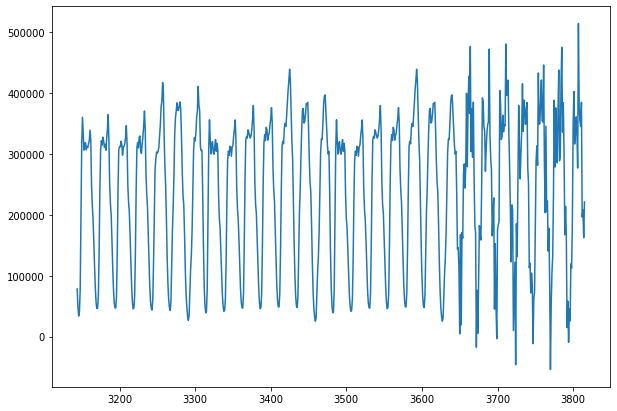

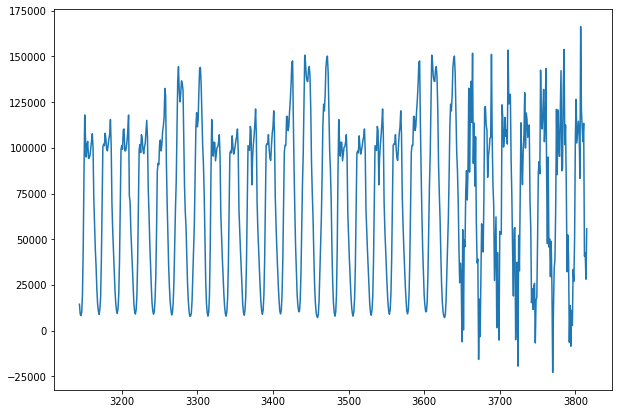

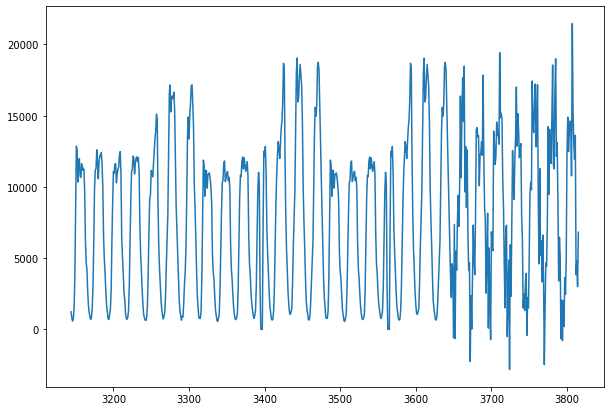

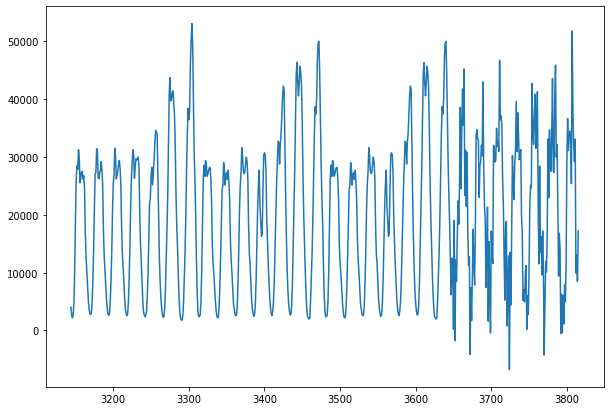

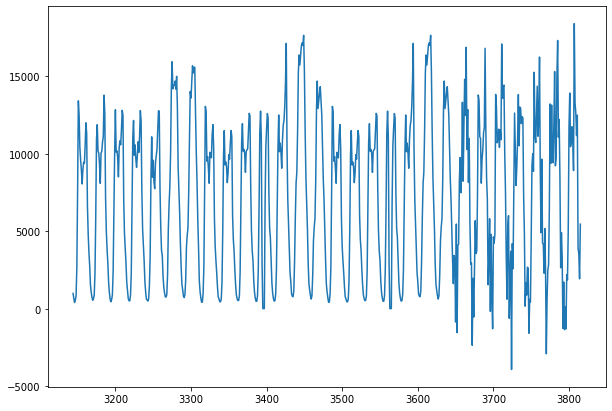

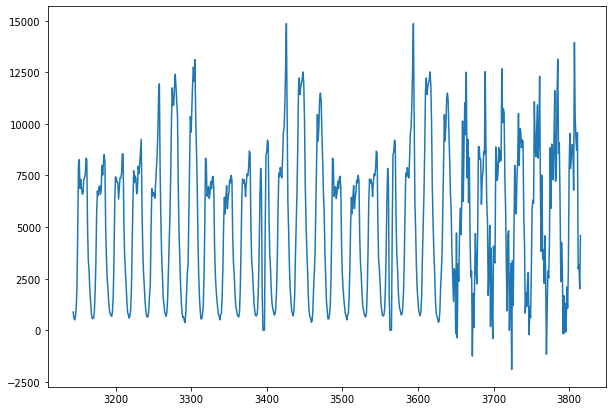

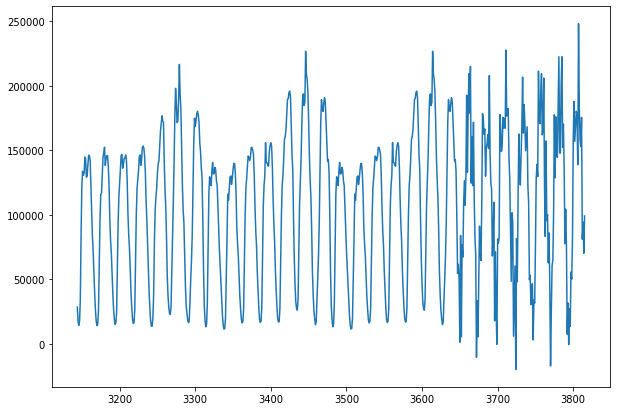

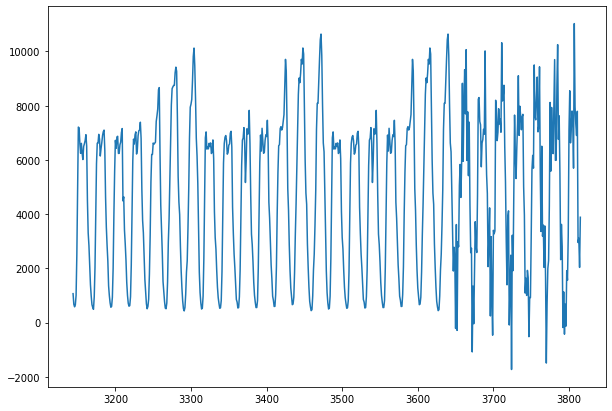

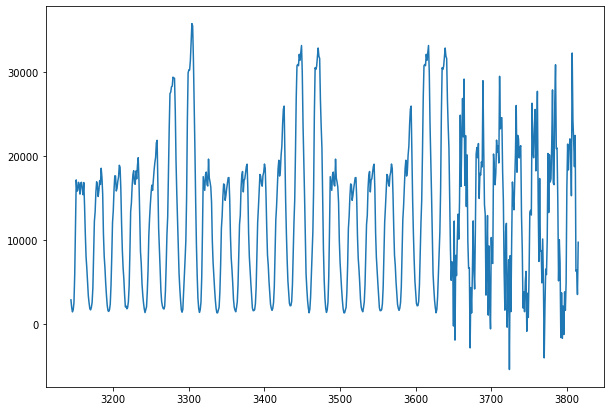

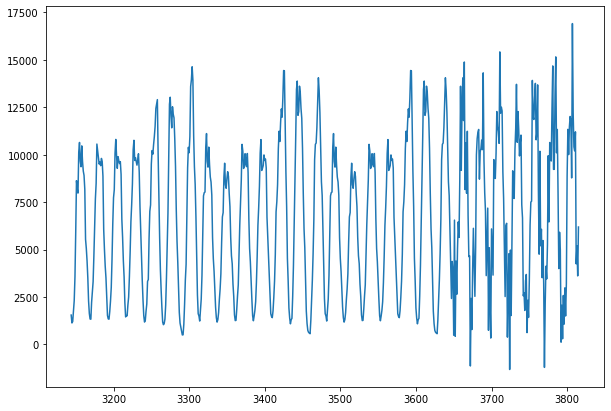

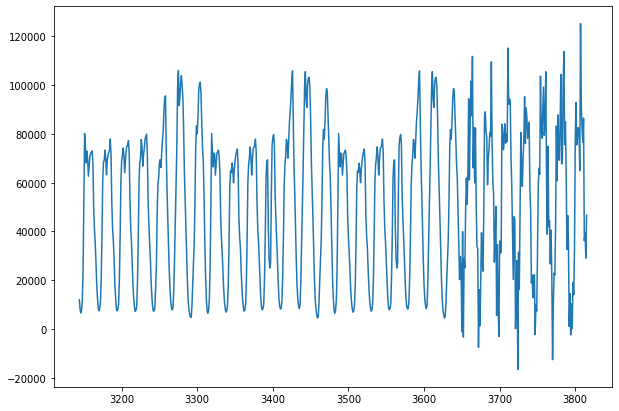

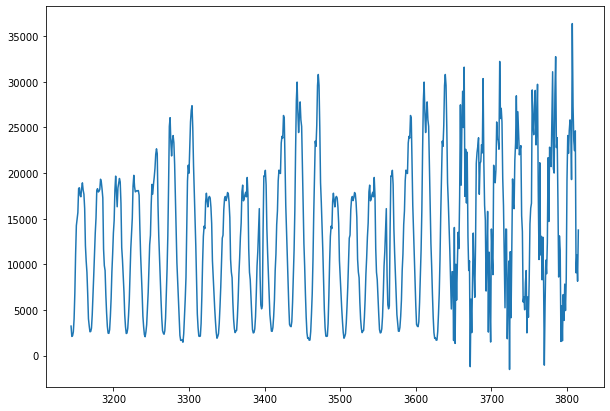

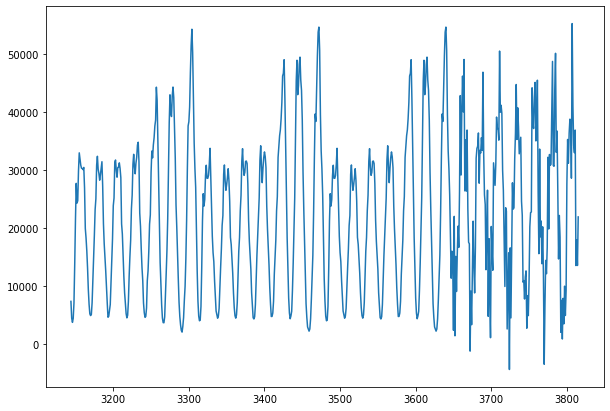

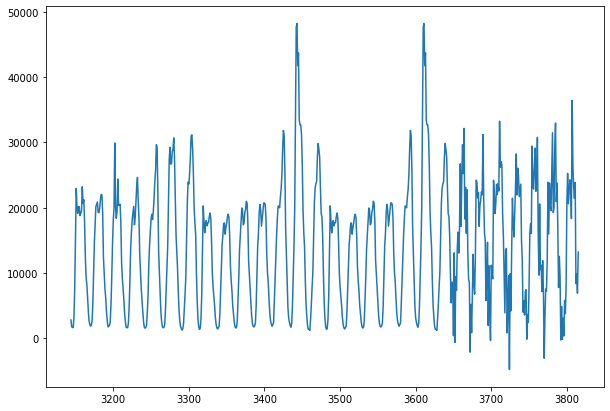

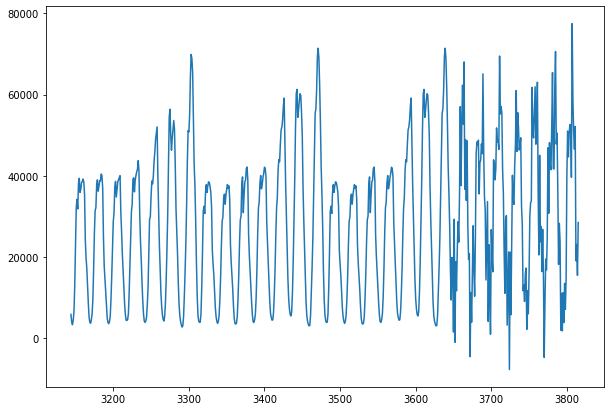

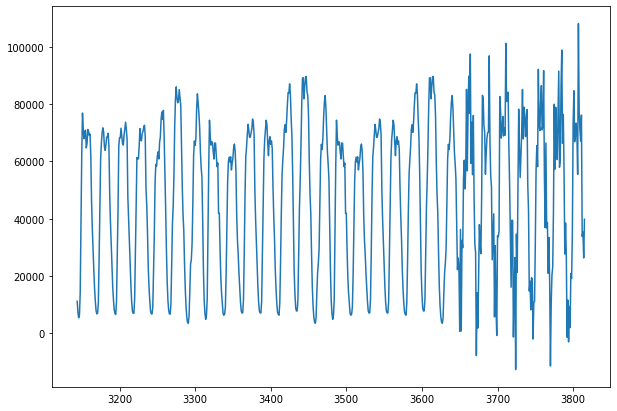

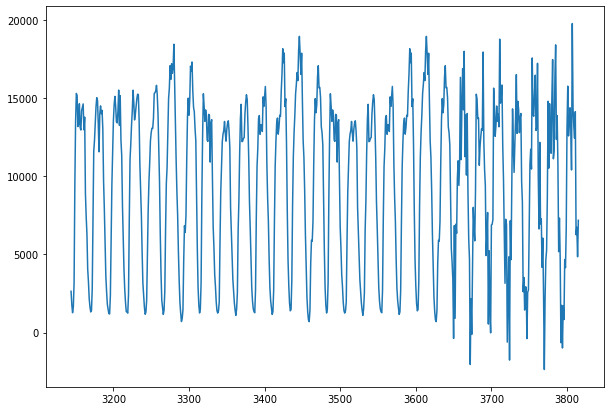

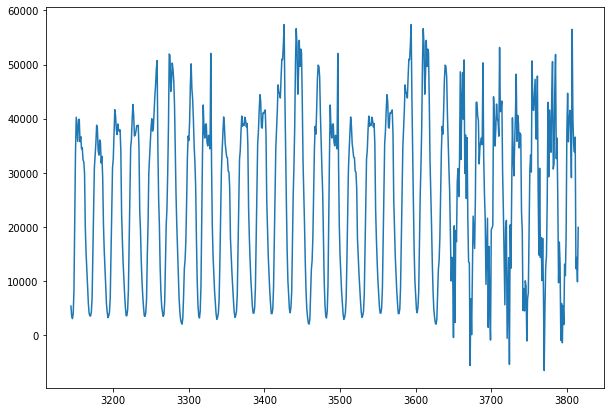

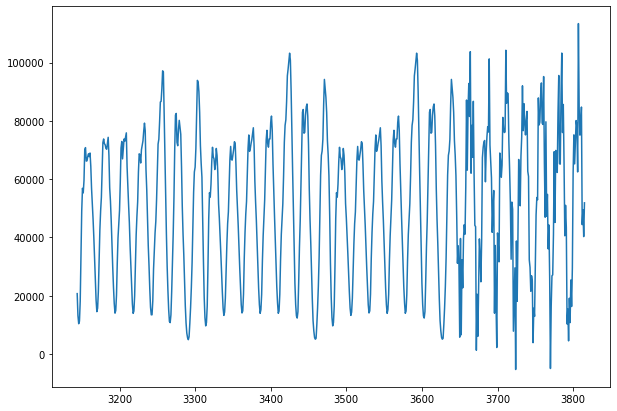

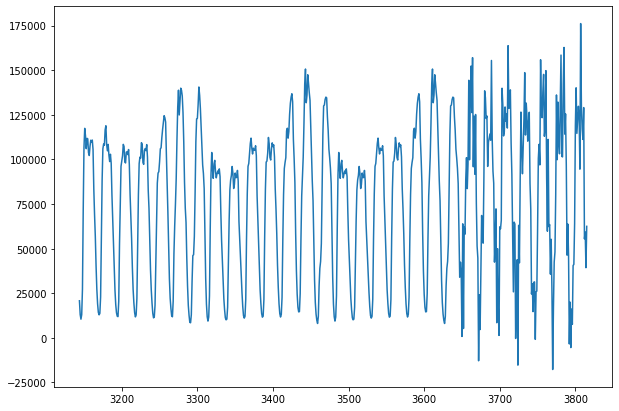

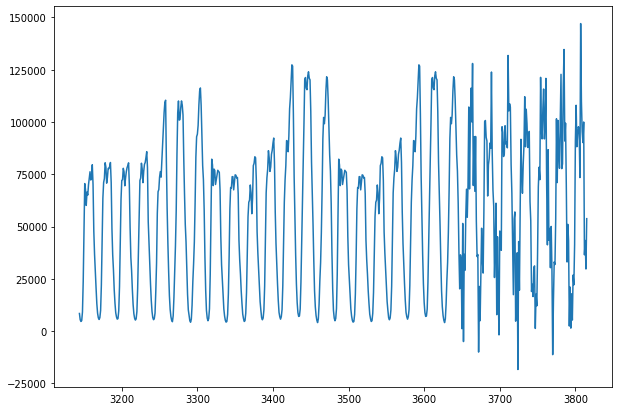

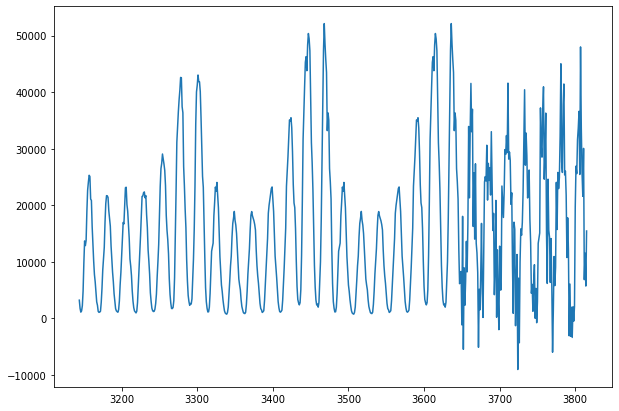

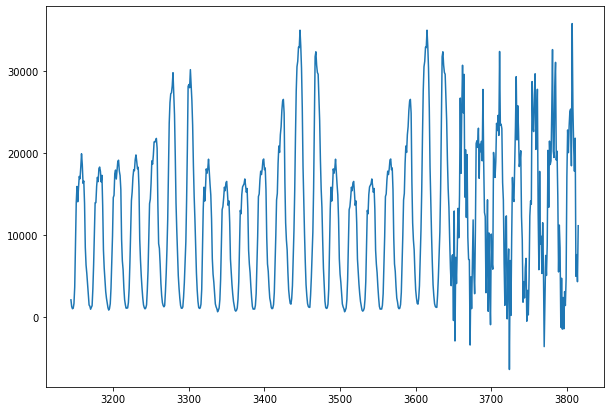

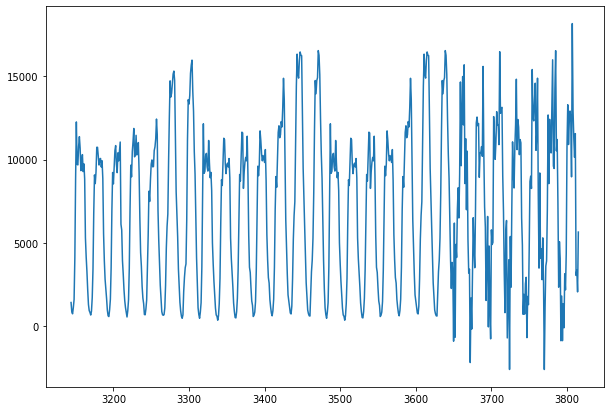

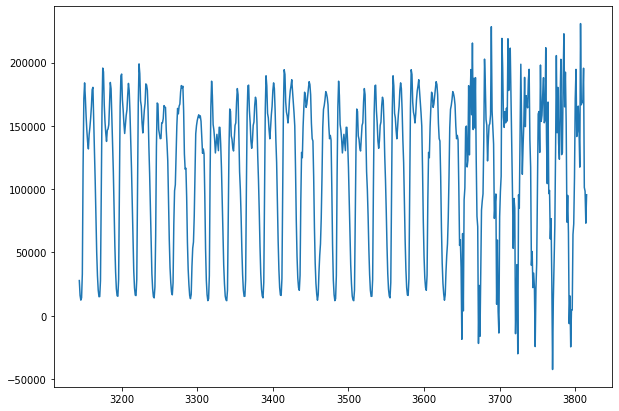

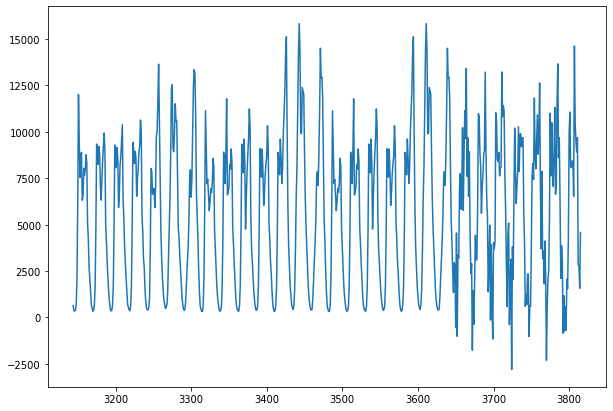

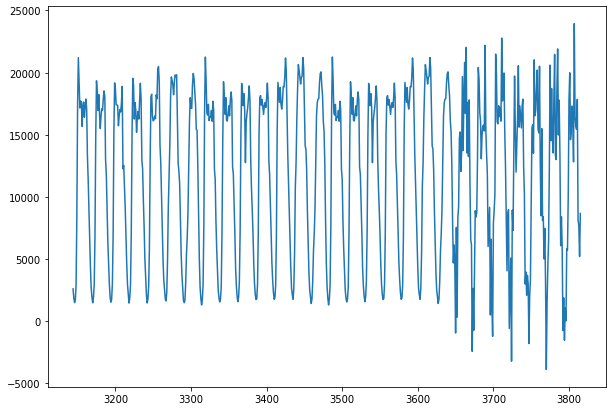

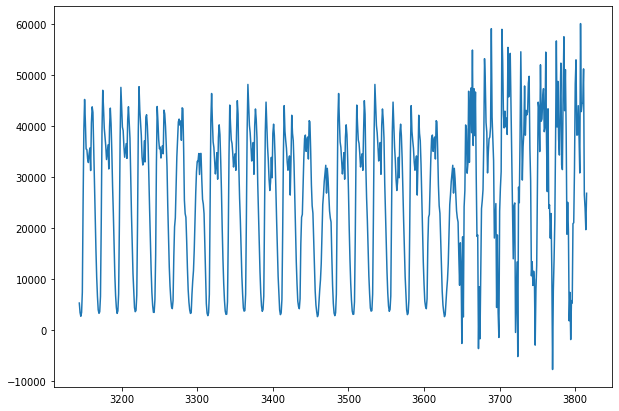

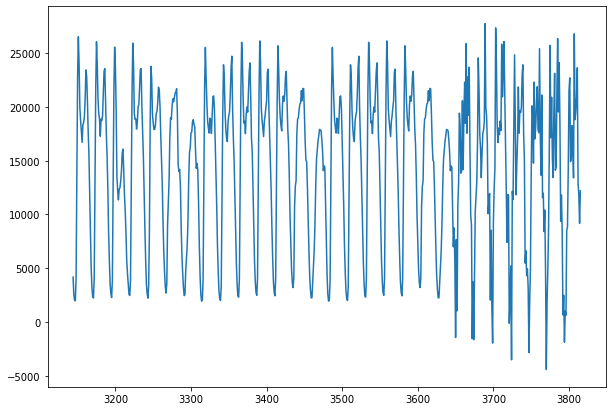

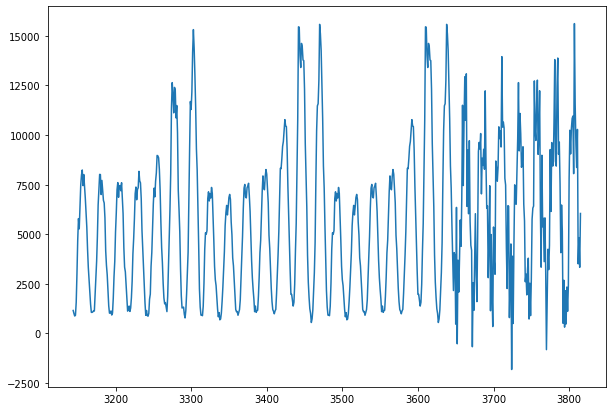

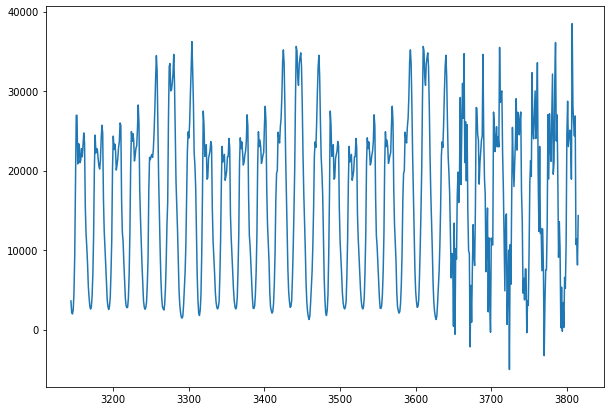

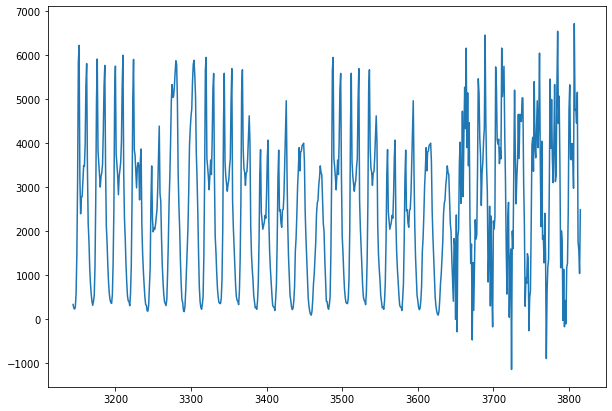

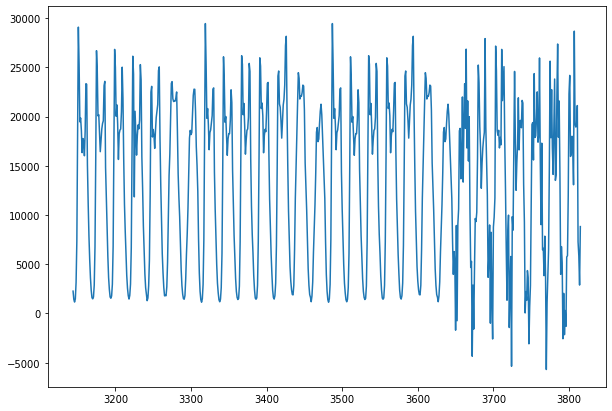

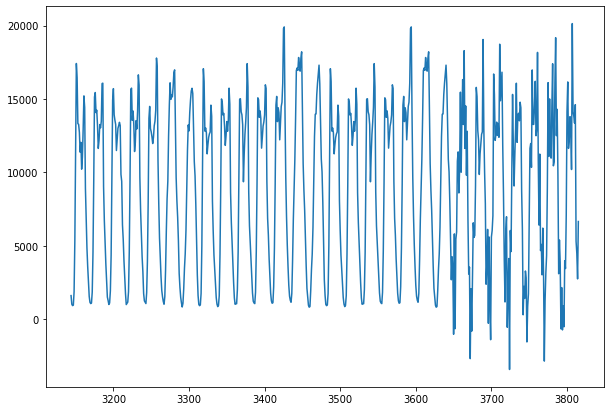

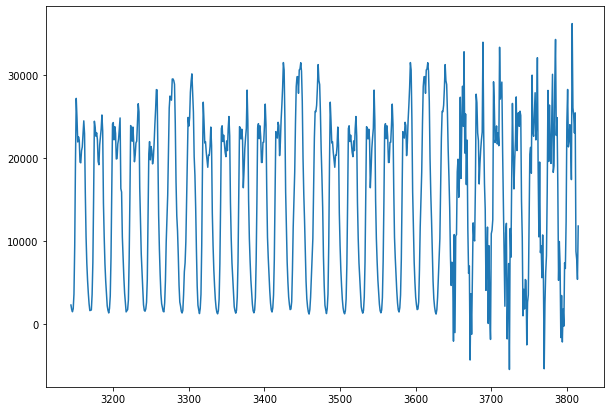

In [39]:
for i in range(len(df_col[2:])) :
    plt.figure(figsize=(10,7))
    plt.plot(df_test.index[-672:],df_test[df_col[i+2]].iloc[-672:])
    plt.show()

In [40]:
submission_file_path = os.path.join(data_dir,'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [41]:
sub_col = submission_table.columns.values

In [42]:
for i in range(len(sub_col[1:])) :
    submission_table[sub_col[i+1]] = test_set[sub_col[i+1]]

In [43]:
submission_table.to_csv('v004_submission.csv',index=False)

In [48]:
submission_table.head()

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,97453,20943,3749,5957,2658,841,39165,3202,5814,...,2832,4240,8120,5613,2000,4693,964,1919,355,2905
1,20200525_1,65246,10065,222,376,1450,699,16874,548,176,...,116,1837,6724,4302,21,1324,550,1293,-420,-496
2,20200525_2,31676,1312,-2496,-1258,-1707,88,2498,360,-1565,...,-799,-1167,2699,949,8,-1067,-775,-1383,-1325,-1017
3,20200525_3,46239,11217,-504,4267,-883,1543,20060,2093,2697,...,1562,-629,1640,1450,3089,1935,-2096,-868,-54,2560
4,20200525_4,89323,20705,525,4937,272,1398,36839,2279,2904,...,1146,2231,10315,6759,2577,4060,-1622,1789,1412,5605
